In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [2]:
import pandas as pd
import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Define the number of rows
num_rows = 500000

# Generate synthetic data
data = {
    "Industry Type": np.random.choice(["Manufacturing", "Retail", "Service", "IT", "Construction"], num_rows),
    "Annual Sales (Revenue)": np.random.uniform(1e5, 1e9, num_rows),
    "Net Income": np.random.uniform(1e4, 1e7, num_rows),
    "Total Assets": np.random.uniform(5e5, 1e9, num_rows),
    "Current Ratio": np.random.uniform(0.5, 3, num_rows),
    "Quick Ratio": np.random.uniform(0.5, 3, num_rows),
    "Debt to Equity Ratio": np.random.uniform(0.1, 2, num_rows),
    "Return on Assets (ROA)": np.random.uniform(-0.1, 0.3, num_rows),
    "Return on Equity (ROE)": np.random.uniform(-0.1, 0.5, num_rows),
    "Gross Profit Margin": np.random.uniform(10, 70, num_rows),
    "Operating Profit Margin": np.random.uniform(5, 65, num_rows),
    "Net Profit Margin": np.random.uniform(0, 30, num_rows),
    "Total Liabilities": np.random.uniform(1e5, 1e8, num_rows),
    "Total Shareholder Equity": np.abs(np.random.uniform(1e4, 1e8, num_rows)),
    "Number of Employees": np.random.randint(10, 50, num_rows),
    "Age of the Company": np.random.randint(1, 36, num_rows),

    "UrbanORRural": np.random.choice(["Urban", "Rural"], num_rows),
    # "NAICS Code": np.random.randint(111110, 812990, num_rows),
    "NewExist": np.random.choice(["New", "Exist"], num_rows),
    "Credit Score": np.random.randint(300, 850, num_rows),
    "Number of Existing Loans": np.random.randint(0, 5, num_rows),
    "Percentage of On-time Payments": np.random.uniform(30, 100, num_rows),
    "Number of Missed or Late Payments": np.random.randint(0, 5, num_rows),
     "Loan Amount Requested": np.random.uniform(5e4, 1e7, num_rows),
}

# Create a DataFrame
df = pd.DataFrame(data)

# Function to determine the approved amount
def calculate_approved_amount(requested, credit_score, missed_payments):
    reduction = 0.02 * (850 - credit_score) / 550 + 0.02 * missed_payments
    return max(0, requested * (1 - reduction))

import random

import random

def determine_loan_status(row):
    conditions = (
        row['Debt to Equity Ratio'] < 0.5 and
        row['Current Ratio'] > 1.5 and
        row['Net Profit Margin'] > 0.1 and
        row['Credit Score'] > 600 and
        row['Number of Existing Loans'] == 0 and
        row['Percentage of On-time Payments'] > 80 and
        row['Number of Missed or Late Payments'] == 0
    )

    # Introduce random noise for noisy approvals
    noisy_approval_chance = 0.1  # Decreased noise level
    random_approval = random.random() < noisy_approval_chance

    return "Approved" if conditions or random_approval else "Rejected"



# Apply the functions
df['Approved Amount'] = df.apply(lambda x: calculate_approved_amount(x['Loan Amount Requested'], x['Credit Score'], x['Number of Missed or Late Payments']), axis=1)
df['Loan Status'] = df.apply(determine_loan_status, axis=1)
# Function to determine risk category based on specified criteria
def determine_risk_category(row):
    # Define criteria for each risk category
    high_risk_criteria = {
        "Debt to Equity Ratio": lambda x: x > 1,
        "Current Ratio": lambda x: x < 1,
        "Net Profit Margin": lambda x: x < 0.05,
        "Credit Score": lambda x: x < 620,
        "Number of Existing Loans": lambda x: x >= 3,
        "Percentage of On-time Payments": lambda x: x < 70,
        "Number of Missed or Late Payments": lambda x: x >= 2
    }

    medium_risk_criteria = {
        "Debt to Equity Ratio": lambda x: x > 0.5,
        "Current Ratio": lambda x: 1 <= x <= 2,
        "Net Profit Margin": lambda x: 0.05 <= x < 0.1,
        "Credit Score": lambda x: 600 <= x < 700,
        "Number of Existing Loans": lambda x: 1 <= x < 3,
        "Percentage of On-time Payments": lambda x: 70 <= x < 85,
        "Number of Missed or Late Payments": lambda x: 1 <= x < 2
    }

    # Check if the row meets the criteria for each risk category
    high_risk_conditions = all(condition(row[column]) for column, condition in high_risk_criteria.items())
    medium_risk_conditions = all(condition(row[column]) for column, condition in medium_risk_criteria.items())

    # Return the appropriate risk category
    if high_risk_conditions:
        return "High Risk"
    elif medium_risk_conditions:
        return "Medium Risk"
    else:
        return "Low Risk"

# Apply the function to create a new column for risk category
df['Risk_Category'] = df.apply(determine_risk_category, axis=1)
# Define interest rate ranges for each risk category
# Define a function to calculate tenure in months based on some criteria
def calculate_tenure(row):
    # Define the range for short, medium, and long tenure in months
    short_tenure_range = (6, 12)   # 6 to 12 months
    medium_tenure_range = (12, 24)  # 12 to 24 months
    long_tenure_range = (24, 36)    # 24 to 36 months

    # Define criteria for determining tenure
    if row['Number of Existing Loans'] == 0:
        return np.random.randint(*short_tenure_range)  # Short tenure
    elif row['Number of Existing Loans'] == 1:
        return np.random.randint(*medium_tenure_range)  # Medium tenure
    else:
        return np.random.randint(*long_tenure_range)  # Long tenure

# Apply the function to create a new column representing tenure
df['Loan_Tenure_Months'] = df.apply(calculate_tenure, axis=1)

# Define interest rate ranges for each tenure category
interest_rate_ranges = {
    (6, 12): (0.05, 0.08),   # Short tenure
    (12, 24): (0.08, 0.12),  # Medium tenure
    (24, 36): (0.12, 0.15)   # Long tenure
}

# Function to determine interest rate based on loan tenure
def determine_interest_rate(row):
    tenure = row['Loan_Tenure_Months']
    for tenure_range, interest_rate_range in interest_rate_ranges.items():
        if tenure_range[0] <= tenure <= tenure_range[1]:
            return np.random.uniform(*interest_rate_range)
    # Default interest rate for unknown tenure
    return np.random.uniform(0.08, 0.12)

# Apply the function to create a new column for interest rate
df['Interest_Rate'] = df.apply(determine_interest_rate, axis=1)
df.drop('Risk_Category',axis=1)

num_rows = len(df)
min_value = 10000000
max_value = 1000000000

# Generate unique random numbers until we have enough unique values
unique_ids = set()
while len(unique_ids) < num_rows:
    unique_ids.add(np.random.randint(min_value, max_value))


# Convert set to a list and assign it to the TAN_ID column
df['TAN_ID'] = list(unique_ids)
# Save the DataFrame to a CSV file
df.to_csv('SME_Loan_Applications_Detailed.csv', index=False)

In [3]:
df=pd.read_csv('SME_Loan_Applications_Detailed.csv')

In [4]:
df.columns

Index(['Industry Type', 'Annual Sales (Revenue)', 'Net Income', 'Total Assets',
       'Current Ratio', 'Quick Ratio', 'Debt to Equity Ratio',
       'Return on Assets (ROA)', 'Return on Equity (ROE)',
       'Gross Profit Margin', 'Operating Profit Margin', 'Net Profit Margin',
       'Total Liabilities', 'Total Shareholder Equity', 'Number of Employees',
       'Age of the Company', 'UrbanORRural', 'NewExist', 'Credit Score',
       'Number of Existing Loans', 'Percentage of On-time Payments',
       'Number of Missed or Late Payments', 'Loan Amount Requested',
       'Approved Amount', 'Loan Status', 'Risk_Category', 'Loan_Tenure_Months',
       'Interest_Rate', 'TAN_ID'],
      dtype='object')

In [5]:
df.columns

Index(['Industry Type', 'Annual Sales (Revenue)', 'Net Income', 'Total Assets',
       'Current Ratio', 'Quick Ratio', 'Debt to Equity Ratio',
       'Return on Assets (ROA)', 'Return on Equity (ROE)',
       'Gross Profit Margin', 'Operating Profit Margin', 'Net Profit Margin',
       'Total Liabilities', 'Total Shareholder Equity', 'Number of Employees',
       'Age of the Company', 'UrbanORRural', 'NewExist', 'Credit Score',
       'Number of Existing Loans', 'Percentage of On-time Payments',
       'Number of Missed or Late Payments', 'Loan Amount Requested',
       'Approved Amount', 'Loan Status', 'Risk_Category', 'Loan_Tenure_Months',
       'Interest_Rate', 'TAN_ID'],
      dtype='object')

In [6]:
from sklearn.preprocessing import LabelEncoder

# Creating a instance of label Encoder.
le = LabelEncoder()

# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(df['Industry Type'])
df['Industry Type']=label

# # printing label


In [7]:
df.columns

Index(['Industry Type', 'Annual Sales (Revenue)', 'Net Income', 'Total Assets',
       'Current Ratio', 'Quick Ratio', 'Debt to Equity Ratio',
       'Return on Assets (ROA)', 'Return on Equity (ROE)',
       'Gross Profit Margin', 'Operating Profit Margin', 'Net Profit Margin',
       'Total Liabilities', 'Total Shareholder Equity', 'Number of Employees',
       'Age of the Company', 'UrbanORRural', 'NewExist', 'Credit Score',
       'Number of Existing Loans', 'Percentage of On-time Payments',
       'Number of Missed or Late Payments', 'Loan Amount Requested',
       'Approved Amount', 'Loan Status', 'Risk_Category', 'Loan_Tenure_Months',
       'Interest_Rate', 'TAN_ID'],
      dtype='object')

In [8]:
import numpy as np
df['Loan Status'] = np.where(df['Loan Status']=='Approved', 1, 0)
df['UrbanORRural'] = np.where(df['UrbanORRural']=='True', 1, 0)
df['NewExist'] = np.where(df['NewExist']=='New', 1, 0)
df['Loan_per_Approved']=df['Loan Amount Requested']/df['Approved Amount']
df=df.drop('Approved Amount', axis=1)

In [9]:
print(df['Loan Status'].value_counts())

Loan Status
0    449265
1     50735
Name: count, dtype: int64


In [10]:
# Check for NaN values
nan_values = df.isna()

# Count NaN values in each column
nan_counts = nan_values.sum()

In [11]:
df=df.drop('Risk_Category',axis=1)

In [12]:
df.columns = df.columns.str.replace(' ', '_')

In [13]:
df.columns

Index(['Industry_Type', 'Annual_Sales_(Revenue)', 'Net_Income', 'Total_Assets',
       'Current_Ratio', 'Quick_Ratio', 'Debt_to_Equity_Ratio',
       'Return_on_Assets_(ROA)', 'Return_on_Equity_(ROE)',
       'Gross_Profit_Margin', 'Operating_Profit_Margin', 'Net_Profit_Margin',
       'Total_Liabilities', 'Total_Shareholder_Equity', 'Number_of_Employees',
       'Age_of_the_Company', 'UrbanORRural', 'NewExist', 'Credit_Score',
       'Number_of_Existing_Loans', 'Percentage_of_On-time_Payments',
       'Number_of_Missed_or_Late_Payments', 'Loan_Amount_Requested',
       'Loan_Status', 'Loan_Tenure_Months', 'Interest_Rate', 'TAN_ID',
       'Loan_per_Approved'],
      dtype='object')

In [21]:
df[df['Loan_Status']==1]['TAN_ID']

12        192938010
32        395313216
35        603979844
44        763363416
51        413139052
            ...    
499905    997195565
499906    929038123
499912    639631176
499934     63962989
499981    714080216
Name: TAN_ID, Length: 50735, dtype: int64

In [39]:
test_df = df.drop([ 'Interest_Rate', 'Loan_per_Approved','Loan_Amount_Requested','Loan_Tenure_Months'], axis=1)
test_df[test_df['Loan_Status']==1]['TAN_ID']

12        192938010
32        395313216
35        603979844
44        763363416
51        413139052
            ...    
499905    997195565
499906    929038123
499912    639631176
499934     63962989
499981    714080216
Name: TAN_ID, Length: 50735, dtype: int64

In [40]:
test_df=test_df.drop("Loan_Status",axis=1)

In [41]:
test_df.to_csv('test_final.csv')

In [ ]:
X = df.drop(['Loan_Status', 'Interest_Rate', 'Loan_per_Approved','TAN_ID'], axis=1)
y=df['Loan_Status']
len(X.columns)

In [38]:
X = df.drop(['Loan_Status', 'Interest_Rate', 'Loan_per_Approved','TAN_ID'], axis=1)
y=df['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_train)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

# Show how inferences were made
# print("\nInference Examples:")
# for i in range(len(X_test)):
#     prediction = model.predict(X_test.iloc[[i]])
#     print(f"Features: {X_test.iloc[i].values}, Predicted Label: {prediction}, True Label: {y_test.iloc[i]}")

Accuracy: 0.8991325


In [ ]:
len(X_train.columns)

In [ ]:
X_train.columns

In [27]:
# Save the trained model to a file
import pickle
with open('prediction_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully.")

Model saved successfully.


In [34]:
import pickle

# Load the saved model from file
with open('prediction_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [28]:
import pickle

# Load the saved model from file
with open('xgboost_model.pkl', 'rb') as file:
    model = pickle.load(file)



FileNotFoundError: [Errno 2] No such file or directory: 'xgboost_model.pkl'

In [29]:
import numpy as np

# Assuming your XGBoost model is named 'model'
# Assuming your test data is named 'x_test'

# Choose just one row of test data
test_row = test_df.iloc[[170]]
print(y_test.iloc[[170]])
# Get the prediction probabilities from your model for the selected row
prediction_probs = model.predict_proba(test_row)
predicted_class = np.argmax(prediction_probs)

# Get the booster of the model
booster = model.get_booster()

# Get the indices of the top 5 most important features
importance_scores = model.feature_importances_
top5_indices =  np.argsort(importance_scores)[-5:]

# Initialize a list to store the top 5 rules
top5_rules = []

# Get the tree associated with the predicted class
tree = booster.get_dump()[predicted_class]

# # Initialize a list to store the top 5 rules
top5_rules = []

# Initialize a list to store the top 5 rules
top5_rules = []

# Initialize a list to store the top 5 rules
top5_rules = []

# Parse the tree to extract the split conditions based on the input data
for line in tree.split('\n'):
    for i in top5_indices:
        feature_name = X_test.columns[i]
        if feature_name in line:
            feature_value = test_row.iloc[0, i]
            split_info = line.strip()
            # Split the line by whitespace
            parts = split_info.split()
            for part in parts:
                if '<=' in part :
                  operator='<='

                elif '<' in part:
                  operator='<'
                elif '>=' in part:
                  operator='>='
                elif '>' in part:
                  operator='>'


                split_value =float(parts[0][parts[0].index(operator)+1:-1])



                # Check if the split condition is satisfied
                if (operator == "<=" and feature_value <= split_value) or \
                    (operator == "<" and feature_value < split_value) or \
                    (operator == ">=" and feature_value >= split_value) or \
                    (operator == ">" and feature_value > split_value):
                    top5_rules.append(split_info)
                    break  # No need to check further if condition is satisfied

# Convert split conditions to if-else statements
if_else_statements = []
# print(top5_rules)

# Print the top 5 rules as if-else statements
print("Top 5 Rules as If-Else Statements:")
pattern = r'\[(.*?)\]'

# Use re.findall() to extract text between square brackets
import re
for statement in top5_rules:
    print(re.findall(pattern, statement))


120950    0
Name: Loan_Status, dtype: int64
Top 5 Rules as If-Else Statements:
['Current_Ratio<2.56904888']
['Percentage_of_On-time_Payments<99.450531']
['Credit_Score<816']


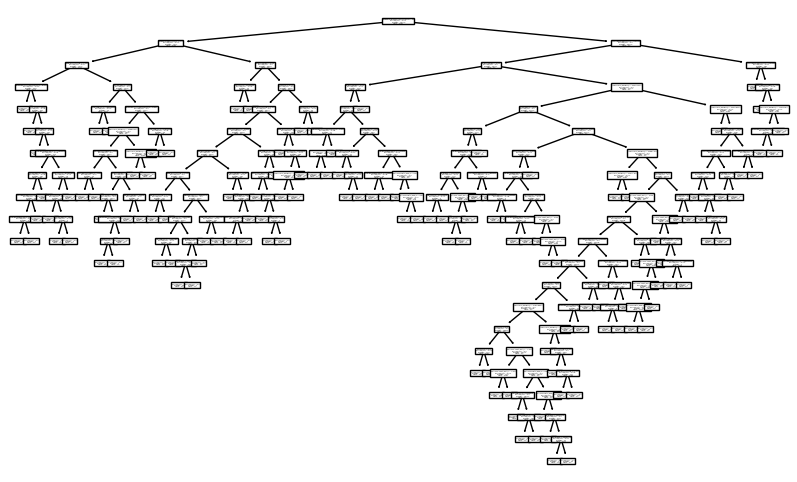

In [ ]:
df.columns


Index(['Industry_Type', 'Annual_Sales_(Revenue)', 'Net_Income', 'Total_Assets',
       'Current_Ratio', 'Quick_Ratio', 'Debt_to_Equity_Ratio',
       'Return_on_Assets_(ROA)', 'Return_on_Equity_(ROE)',
       'Gross_Profit_Margin', 'Operating_Profit_Margin', 'Net_Profit_Margin',
       'Total_Liabilities', 'Total_Shareholder_Equity', 'Number_of_Employees',
       'Age_of_the_Company', 'Loan_Amount_Requested', 'UrbanORRural',
       'NewExist', 'Credit_Score', 'Number_of_Existing_Loans',
       'Percentage_of_On-time_Payments', 'Number_of_Missed_or_Late_Payments',
       'Approved_Amount', 'Loan_Status'],
      dtype='object')

In [30]:
# Perform train-test split
from sklearn.metrics import mean_squared_error
X = df.drop(['Loan_Status', 'Interest_Rate', 'Loan_per_Approved','TAN_ID'], axis=1)
y=df['Loan_per_Approved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_train)

# Evaluate model performance
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error:", mse)

# Show how inferences were made
# print("\nInference Examples:")
# for i in range(len(X_test)):
#     prediction = model.predict(X_test.iloc[[i]])
#     print(f"Features: {X_test.iloc[i].values}, Predicted Label: {prediction}, True Label: {y_test.iloc[i]}")

Mean Squared Error: 4.897493578769116e-09


In [31]:
# Save the trained model to a file
import pickle
with open('approved.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully.")

Model saved successfully.


In [32]:
# Perform train-test split
from sklearn.metrics import mean_squared_error
X = df.drop(['Loan_Status', 'Interest_Rate', 'Loan_per_Approved','TAN_ID'], axis=1)
y=df['Interest_Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_train)

# Evaluate model performance
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error:", mse)

# Show how inferences were made
# print("\nInference Examples:")
# for i in range(len(X_test)):
#     prediction = model.predict(X_test.iloc[[i]])
#     print(f"Features: {X_test.iloc[i].values}, Predicted Label: {prediction}, True Label: {y_test.iloc[i]}")

Mean Squared Error: 8.363877945572547e-05


In [33]:
# Save the trained model to a file
import pickle
with open('interest.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully.")

Model saved successfully.
